[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ada-k/GANSinAction-TheLangrBook/blob/main/variational_autoencoder.ipynb)

In [ ]:
# standard imports
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [ ]:
# hyperparams
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

In [ ]:
# encoder creation

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (batch_size, latent_dim), mean = 0.)
    return z_mean + K.exp(z_log_var/2) * epsilon 

x = Input(shape = (original_dim,), name = 'input')
h = Dense(intermediate_dim, activation = 'relu', name = 'encoding')(x) #intermediate layer
z_mean = Dense(latent_dim, name = 'mean')(h) # mean of latent space
z_log_var = Dense(latent_dim, name = 'log-variance')(h) #log variance of latent space
z  = Lambda(sampling, output_shape = (latent_dim,)) ([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name = 'encoder') # encoder as a keras model == compiling the model
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

In [ ]:
# decoder creation
input_decoder = Input(shape = (latent_dim,), name = 'decoder_input')
decoder_h = Dense(intermediate_dim, activation = 'relu', name = 'decoder_h')(input_decoder)
x_decoded = Dense(original_dim, activation = 'sigmoid', name = 'flat_decoded')(decoder_h) #gets mean from original dim
decoder = Model(input_decoder, x_decoded, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# combining encoder and decoder into single VAE model
output_combined = decoder(encoder(x)[2]) # grabs output and 3rd element of our sampling z
vae = Model(x, output_combined) #link input and overall output
vae.summary() #model summary

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (1 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# custom loss function definition

'''KL  divergence  measures  the  difference  between  distributions;  
imagine two blobs then measuring the volume of overlap.
Binarycross-entropy : compare each grayscale pixel value of x to the value in x_decoded_mean'''

def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

In [ ]:
# compile the model
vae.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy') # should use the customised loss function but cause of some error - we use this meanwhile
vae.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (1 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train/test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
# lets train
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size)

Epoch 1/5
600/600 [==============================] - 8s 11ms/step - loss: 0.2612
Epoch 2/5
600/600 [==============================] - 7s 11ms/step - loss: 0.2075
Epoch 3/5
600/600 [==============================] - 7s 12ms/step - loss: 0.2008
Epoch 4/5
600/600 [==============================] - 7s 11ms/step - loss: 0.1970
Epoch 5/5
600/600 [==============================] - 7s 11ms/step - loss: 0.1947


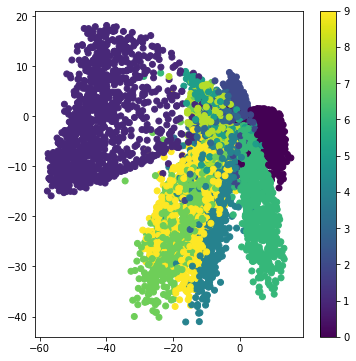

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

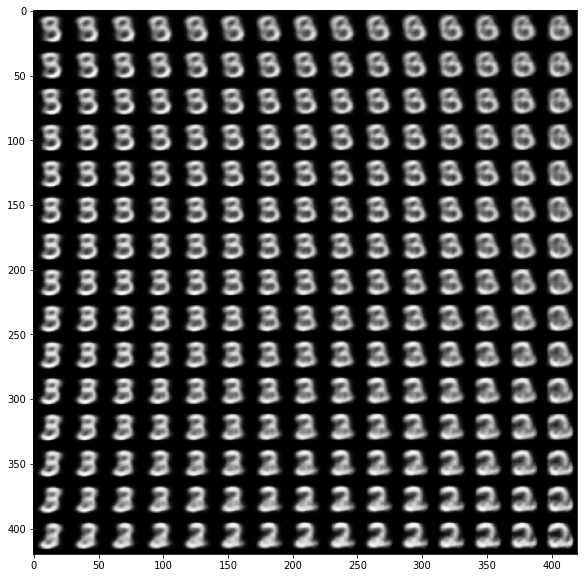

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()